In [2]:
from aggmap import loadmap
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, log_loss
import warnings, os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import copy
from tqdm import tqdm


warnings.filterwarnings("ignore")

from matplotlib.ticker import FormatStrFormatter
#gfc = gfc.rename(columns = {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'})

sns.set(style='white',  font='sans-serif', font_scale=2)  

2022-09-26 15:24:30.631497: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
gfc = pd.read_csv('./fig/00_gfc.csv', index_col=0)
adjp = pd.read_csv('./fig/01_adjp.csv', index_col=0)
coef = pd.read_csv('./fig/02_coef.csv', index_col=0)
gfi = pd.read_csv('./fig/03_gfi.csv', index_col=0)
rfi = pd.read_csv('./fig/04_rfi.csv', index_col=0)

In [93]:
ks = []
for i in range(5):
    for j in range(i):
        if i != j:
            k = gfi.columns[i] + '->' + gfi.columns[j]
            ks.append(k)

In [ ]:
hue

In [155]:
alls = []
for df, name in zip([gfi, rfi, gfc, adjp, coef], ['AggMapNet FI', 'RF FI','Fold change', 'FDR adjusted p',  'LASSO coefficient',]):
    s1 = df.corr().unstack().reset_index()
    s1 = s1[s1.level_0 != s1.level_1]
    
    s1['Method'] = name
    
    s1['Cross'] = s1.level_0 + '->' + s1.level_1

    
    s1["Pearson'r"] = s1[0]
    
    #s1 = s1[s1.Cross.isin(res)]
    
    s1 = s1.sort_values("Pearson'r", ascending=False)
        
    alls.append(s1[['Method', 'Cross', "Pearson'r"]])
    
dfp = pd.concat(alls)

In [156]:
dfp = dfp[dfp.Cross.isin(ks)]

In [157]:
order = dfp.groupby('Cross')["Pearson'r"].max().sort_values().index.tolist()

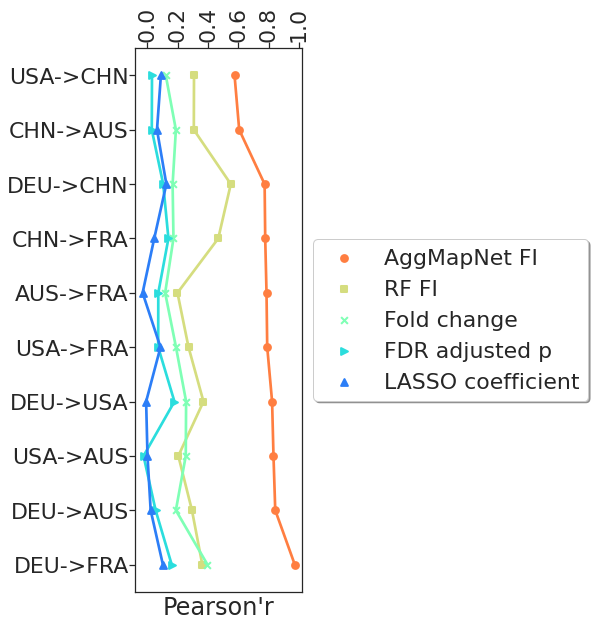

In [169]:
color = sns.color_palette("rainbow_r",5) #PiYG

fig, ax  = plt.subplots(1, 1, figsize=(3, 10))
g = sns.pointplot(x="Pearson'r", y = "Cross", hue = 'Method', data=dfp, lw=2, order=order,
                s=100, alpha=1, markers=['o', 's', 'x', '>', '^'], style='Method',
                  ax=ax,  palette=color, ) #legend=False,

ax.tick_params(axis='y', left='off', labelleft='on', pad=.3,)
ax.tick_params(axis='x', bottom='off', labelleft='on', pad=.3,)

#ax.locator_params(nbins=5)
# Put a legend below current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)

ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8,1])
ax.xaxis.set_ticks_position('top') # the rest is the same

ax.set_ylabel('')

plt.xticks(rotation=90)

plt.subplots_adjust(wspace = 0.18)

plt.savefig('./fig/5_corr.pdf', dpi = 400, bbox_inches="tight")

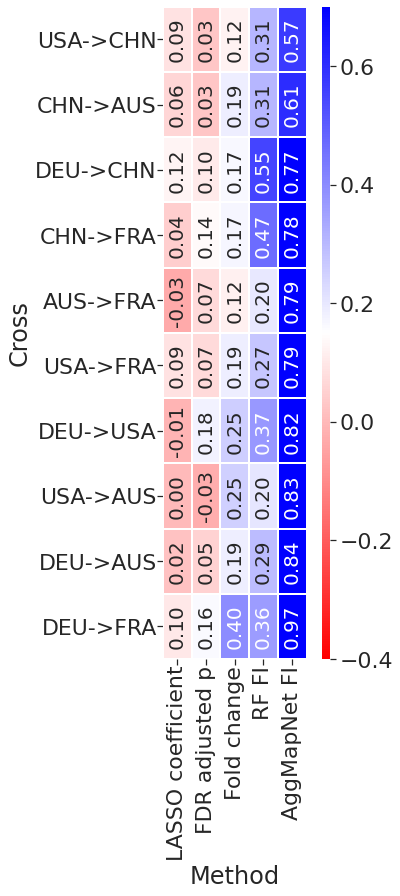

In [198]:
dfp1 = pd.crosstab(dfp.Method, dfp.Cross, dfp["Pearson'r"], aggfunc=np.mean).T

hue_order = ['LASSO coefficient', 'FDR adjusted p','Fold change', 'RF FI',  'AggMapNet FI', ]

dfp1 = dfp1.loc[order][hue_order]

fig, (ax, ax2)  = plt.subplots(1, 2, figsize=(3, 12), gridspec_kw={'width_ratios': [20, 1.2]})

sns.heatmap(dfp1, cmap = 'bwr_r', ax=ax, annot=True, linewidths=.1,  fmt='.2f', cbar_ax= ax2, 
             vmin = -0.4, vmax = 0.7, annot_kws={"fontsize":20, 'rotation':90},)


ax.tick_params(axis='y', left='off', labelleft='on', pad=.3,)
ax.tick_params(axis='x', bottom='off', labelleft='on', pad=.3,)

# # #ax.locator_params(nbins=5)
# # # Put a legend below current axis
# # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
# #           fancybox=True, shadow=True, ncol=1)

# # ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8,1])

#ax.xaxis.set_ticks_position('top') # the rest is the same

# ax.set_ylabel('')

# plt.xticks(rotation=90)

# plt.subplots_adjust(wspace = 0.18)

plt.savefig('./fig/5_corr2.pdf', dpi = 400, bbox_inches="tight")

['USA->CHN',
 'AUS->FRA',
 'CHN->AUS',
 'USA->AUS',
 'DEU->AUS',
 'USA->FRA',
 'CHN->FRA',
 'DEU->USA',
 'DEU->CHN',
 'DEU->FRA']

In [118]:
def get_cross_n(df, top = 50):
    ss = []
    for col in df.columns:
        s = df[col].sort_values(ascending=False)
        idx = s.head(top).index.to_list()
        s1 = set(idx)
        ss.append(s1)
    sn = ss[0] & ss[1] & ss[2] & ss[3] & ss[4]
    return len(sn)

In [119]:
res = []
for top in range(0, 99, 2):
    
    for df, name in zip([gfi, rfi, gfc, adjp, coef, ], ['AggMapNet FI', 'RF FI','Fold change', 
                                                  'FDR adjusted p', 'LASSO coefficient', ]):
        res.append([name, top, get_cross_n(df, top)])


In [120]:
x = 'Top-K Microbes of each country'
y = 'Overlap Microbes \n among 5 countries'
dfp3 = pd.DataFrame(res, columns=['Method', x, y])

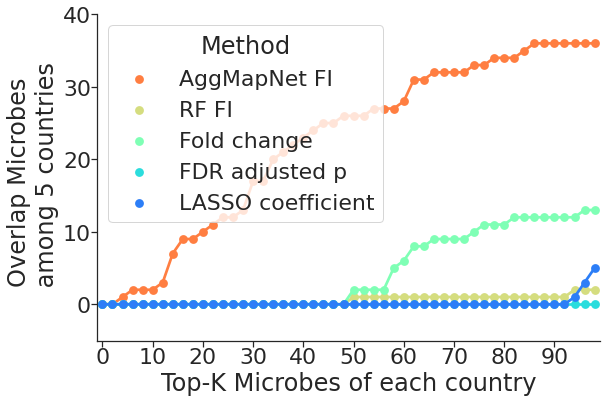

In [121]:
fig, ax  = plt.subplots(1, 1, figsize=(9, 6))

g = sns.pointplot(x=x, y = y, hue = 'Method', data=dfp3, palette=color, ax = ax, lw=4,)

ax.tick_params(axis='y', left='off', labelleft='on', pad=.3,)
ax.tick_params(axis='x', bottom='off', labelleft='on', pad=.3,)
ax.set_ylim(-5, 40)
#ax.set_xlim(0, 100)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.canvas.draw()
new_ticks = [i.get_text() for i in g.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 5), new_ticks[::5])

plt.subplots_adjust(wspace = 0.18)

plt.savefig('./fig/topk.pdf', dpi = 400, bbox_inches="tight")